In [1]:
from time import time
start_time = time()

### Imports

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mapclassify
import esda
import contextily as ctx

### Load and prepare data

In [3]:
# BIG DATASET
# Split 1
#housestr = pd.read_csv(r"Y:\Lukas\thesis\bus1123\data\split1\calhouses3310scat-train1.csv", sep = ";")
#houseste = pd.read_csv(r"Y:\Lukas\thesis\bus1123\data\split1\calhouses3310scat-test1.csv", sep = ";")

# Split 2
#housestr = pd.read_csv(r"Y:\Lukas\thesis\bus1123\data\split2\calhouses3310scat-train2.csv", sep = ";")
#houseste = pd.read_csv(r"Y:\Crime_HU\bus1123\data\split2\calhouses3310scat-test2.csv", sep = ";")

# Split 3
#housestr = pd.read_csv(r"Y:\Lukas\thesis\bus1123\data\split3\calhouses3310scat-train3.csv", sep = ";")
#houseste = pd.read_csv(r"Y:\Lukas\thesis\bus1123\data\split3\calhouses3310scat-test3.csv", sep = ";")

# SMALL DATASET
# Split 1
housestrain = gpd.read_file(r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TRAIN-1_points.shp")
housestest = gpd.read_file(r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TEST-1_points.shp")

# Split 2
#housestrain = gpd.read_file(r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TRAIN-2_points.shp")
#housestest = gpd.read_file(r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TEST-2_points.shp")

# Split 3
#housestrain = gpd.read_file(r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TRAIN-3_points.shp")
#housestest = gpd.read_file(r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TEST-3_points.shp")

housestrain.head(1)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry
0,280200.0,5.0294,27.0,1176.0,416.0,6.427885,1.007212,POINT (18374.356 -397330.047)


In [4]:
# The following lines are only needed for the bog dataset because it is loaded as a csv
'''
housestrain = gpd.GeoDataFrame(
    housestr, geometry=gpd.points_from_xy(housestr.lon, housestr.lat), crs="EPSG:3310"
)
housestest = gpd.GeoDataFrame(
    houseste, geometry=gpd.points_from_xy(houseste.lon, houseste.lat), crs="EPSG:3310"
)
housestest = housestest.drop(["lon", "lat"], axis=1)
housestrain = housestrain.drop(["lon", "lat"], axis=1)

housestrain.head(1)
'''

'\nhousestrain = gpd.GeoDataFrame(\n    housestr, geometry=gpd.points_from_xy(housestr.lon, housestr.lat), crs="EPSG:3310"\n)\nhousestest = gpd.GeoDataFrame(\n    houseste, geometry=gpd.points_from_xy(houseste.lon, houseste.lat), crs="EPSG:3310"\n)\nhousestest = housestest.drop(["lon", "lat"], axis=1)\nhousestrain = housestrain.drop(["lon", "lat"], axis=1)\n\nhousestrain.head(1)\n'

In [5]:
print(housestrain.crs)

EPSG:3310


In [6]:
housestrain['X'] = housestrain['geometry'].x
housestrain['Y'] = housestrain['geometry'].y
print(housestrain.shape)
housestrain.head(1)

(1640, 10)


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,X,Y
0,280200.0,5.0294,27.0,1176.0,416.0,6.427885,1.007212,POINT (18374.356 -397330.047),18374.355842,-397330.047207


In [7]:
housestest['X'] = housestest['geometry'].x
housestest['Y'] = housestest['geometry'].y
print(housestest.shape)
housestest.head(1)

(411, 10)


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,X,Y
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),-6223.35908,-116314.796314


In [8]:
y_train = housestrain["MedHouseVa"].values.reshape((-1, 1))
X_train = housestrain[['MedIncome','MedianAge','Population','Households','roomsperHH','bedroomHH']].values
u_train = housestrain['X']
v_train = housestrain['Y']
coords_train = list(zip(u_train,v_train))

In [9]:
print(y_train.shape)
print(X_train.shape)
print(u_train.shape)
print(v_train.shape)
print(len(coords_train))

(1640, 1)
(1640, 6)
(1640,)
(1640,)
1640


In [10]:
y_test = housestest["MedHouseVa"].values.reshape((-1, 1))
X_test = housestest[['MedIncome','MedianAge','Population','Households','roomsperHH','bedroomHH']].values
u_test = housestest['X']
v_test = housestest['Y']
coords_test = list(zip(u_test,v_test))

In [11]:
print(y_test.shape)
print(X_test.shape)
print(u_test.shape)
print(v_test.shape)
print(len(coords_test))

(411, 1)
(411, 6)
(411,)
(411,)
411


### Bandwidth Selection

In [12]:
gwr_selector = Sel_BW(coords_train, y_train, X_train, fixed=False)
gwr_bw = gwr_selector.search(criterion='AICc')
print(gwr_bw)

82.0


### Calibrate model and predict

In [13]:
%%time
model = GWR(coords_train, y_train, X_train, gwr_bw)
gwr_results = model.fit()

CPU times: total: 12.4 s
Wall time: 685 ms


In [14]:
print(gwr_results.aic)
print(gwr_results.R2)

40364.71026021591
0.8564906569327047


In [15]:
scale = gwr_results.scale
residuals = gwr_results.resid_response

In [16]:
test_coords_array = np.array(coords_test)
test_X_array = np.array(X_test)
test_y_array = np.array(y_test)

In [17]:
# check if the split is done correctly
print("train_coords shape:", np.array(coords_train).shape)
print("train_X shape:", np.array(X_train).shape)
print("train_y shape:", np.array(y_train).shape)
print("test_coords shape:", np.array(coords_test).shape)
print("test_X shape:", np.array(X_test).shape)
print("test_y shape:", np.array(y_test).shape)

train_coords shape: (1640, 2)
train_X shape: (1640, 6)
train_y shape: (1640, 1)
test_coords shape: (411, 2)
test_X shape: (411, 6)
test_y shape: (411, 1)


In [18]:
%%time
test_results = model.predict(test_coords_array, test_X_array, scale, residuals)

CPU times: total: 2.81 s
Wall time: 158 ms


In [19]:
# check if this lines up properly as well
print(test_results.predictions.shape)
print(test_y_array.shape)

(411, 1)
(411, 1)


### Evaluate Results

In [20]:
mae = mean_absolute_error(test_y_array, test_results.predictions)
mse = mean_squared_error(test_y_array, test_results.predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_y_array, test_results.predictions)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

MAE: 44279.87339541773
MSE: 5107859599.86503
RMSE: 71469.29130658167
R2: 0.6168292423022104


In [21]:
print(f'BW used in this run: {gwr_bw}')
print("Time for GWR + prediction: {:.2f} seconds".format(time() - start_time))

BW used in this run: 82.0
Time for GWR + prediction: 10.97 seconds


### LISA

In [22]:
housestest['predictions'] = test_results.predictions.flatten()
housestest['y_test'] = y_test
housestest['test_res'] = housestest['y_test'] - housestest['predictions']

print(housestest.shape)
housestest.head(1)

(411, 13)


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,X,Y,predictions,y_test,test_res
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),-6223.35908,-116314.796314,54894.162935,55000.0,105.837065


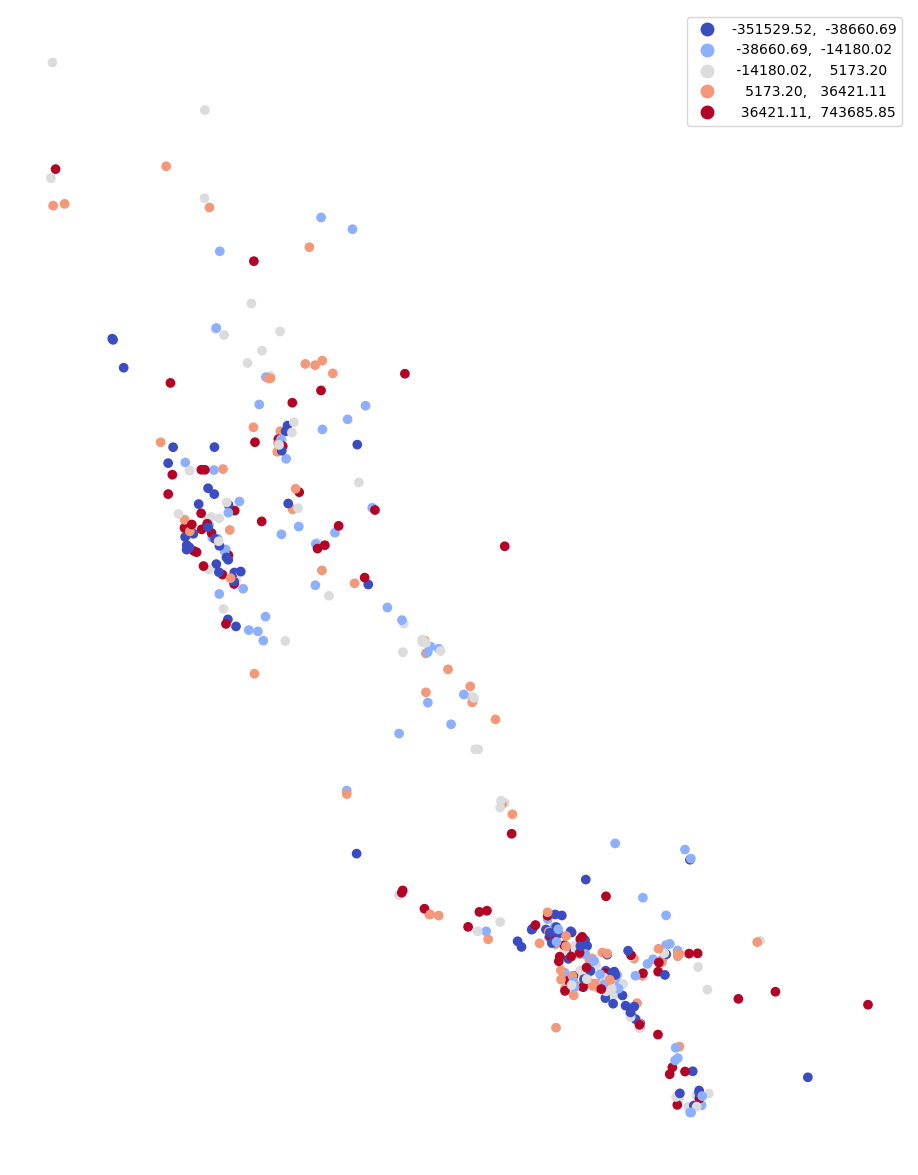

In [23]:
# plot residuals
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'aspect': 'equal'})
housestest.plot(column='test_res', scheme='Quantiles', k=5, cmap='coolwarm', legend=True, ax=ax)
ax.set_axis_off()
save_path = r'Y:\Lukas\thesis\regionalization plots/res_RF.png'
#plt.savefig(save_path)
plt.show()

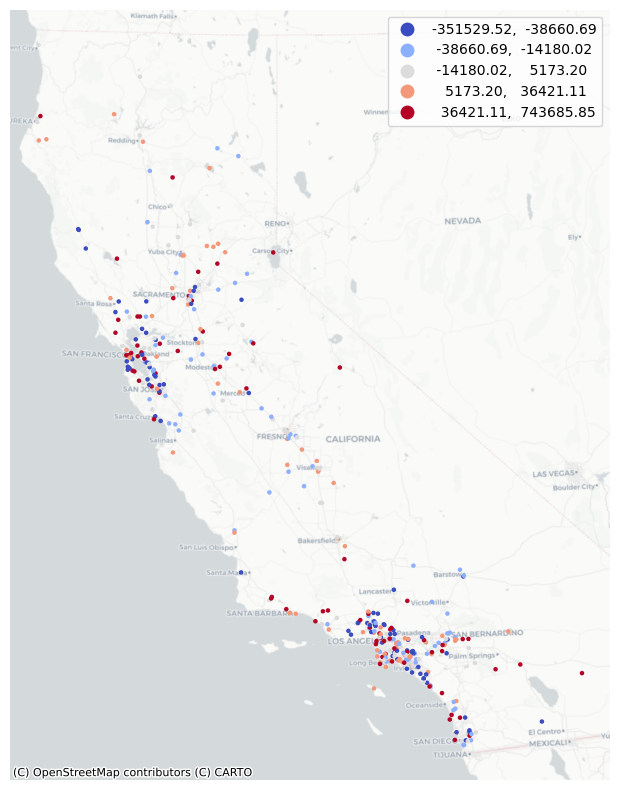

In [24]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': 'equal'})
housestest.plot(column='test_res', scheme='Quantiles', k=5, cmap='coolwarm', legend=True, ax=ax, markersize=5)
ctx.add_basemap(ax, crs=housestest.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
save_path = r'Y:\Lukas\thesis\regionalization plots/basemap_GWR.png'
#plt.savefig(save_path)
plt.show()

In [25]:
# new spatial weights for moran's I
wi = ps.weights.distance.KNN.from_dataframe(housestest, k=7) 
wi.transform = 'r'
y = housestest['test_res']

In [26]:
mi = esda.Moran(y, wi, permutations = 1000, two_tailed=False)
print( 'Moran I is', round(mi.I, 3), 'and p-value is', mi.p_sim, 'expected value is', mi.EI)

Moran I is 0.001 and p-value is 0.42157842157842157 expected value is -0.0024390243902439024


In [27]:
# Calculate LISA
lisa = esda.moran.Moran_Local(y, wi)

In [28]:
# Calculate spatial groupings and significance
housestest['Is'] = lisa.Is
housestest['pvalue'] = lisa.p_sim 
housestest['group'] = lisa.q 
housestest.loc[housestest['pvalue'] > 0.05, 'group'] = 'not-significant'
housestest.loc[housestest['group'] == 1, 'group'] = 'hotspot'
housestest.loc[housestest['group'] == 2, 'group'] = 'cold outlier'
housestest.loc[housestest['group'] == 3, 'group'] = 'coldspot'
housestest.loc[housestest['group'] == 4, 'group'] = 'hot outlier'
print(housestest ['group'].value_counts())
housestest.head(2)

group
not-significant    374
coldspot            13
hot outlier         13
hotspot              7
cold outlier         4
Name: count, dtype: int64


C:\Users\lukasb97\AppData\Local\Temp\ipykernel_5812\1113662505.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'not-significant' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  housestest.loc[housestest['pvalue'] > 0.05, 'group'] = 'not-significant'


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,X,Y,predictions,y_test,test_res,Is,pvalue,group
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),-6223.359080,-116314.796314,54894.162935,55000.0,105.837065,0.003956,0.356,not-significant
1,104200.0,2.1250,16.0,1077.0,520.0,5.046154,1.013462,POINT (60108.280 -192791.957),60108.280241,-192791.956595,86048.437150,104200.0,18151.562850,0.000090,0.456,not-significant


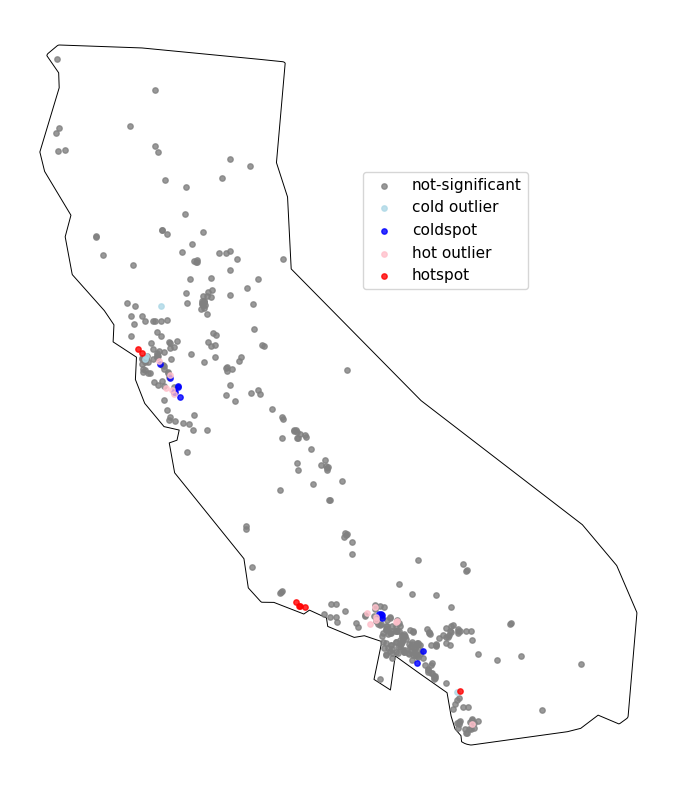

In [29]:
# Vizualize spatial groupings and significance
state_boundary = gpd.read_file(r"Y:/Lukas/thesis/bus1123/bufferedcliprahmen.shp")
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'aspect':'equal'})    

group_colors = {'not-significant': 'grey',
               'hotspot': 'red',
               'coldspot': 'blue',
               'cold outlier': 'lightblue',
               'hot outlier': 'pink'}

state_boundary.plot(ax=ax, edgecolor='black', linewidth=0.7, facecolor='none')

for ctype, data in housestest.groupby('group'):
    if ctype == 'not-significant':
        color = group_colors[ctype]
        data.plot(color=color, ax=ax, label=ctype, markersize=15, alpha=0.8)

for ctype, data in housestest.groupby('group'):
    if ctype != 'not-significant':
        color = group_colors[ctype]
        data.plot(color=color, ax=ax, label=ctype, markersize=15, alpha=0.8)

ax.legend(bbox_to_anchor=(0.8, .8), prop={'size': 11})

ax.set_axis_off()
save_path = r'Y:\Lukas\thesis\regionalization plots/lisa_GWR_S3_small.png'
#plt.savefig(save_path)
plt.show()

### Runtime

In [30]:
print("Time for whole script: {:.2f} seconds".format(time() - start_time))

Time for whole script: 18.67 seconds
